**Image Classification with CNNs**

---
---


This notebook investigates image classification using deep learning on a small, balanced multi-class colour image dataset. A custom Convolutional Neural Network (CNN) is designed and optimized through systematic hyperparameter tuning, and its performance is compared against a transfer learning approach using MobileNetV3Small. The work focuses on model architecture design, regularisation, training efficiency, and detailed performance evaluation using metrics such as accuracy, precision, recall, F1 score, and confusion matrices

---
---


**01. Load relavant Libraries and set enable reproducible**

In [ ]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 1.7 MB/s eta 0:00:00


In [ ]:
# Libraries
import os, random, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks, optimizers
from tensorflow.keras.applications import MobileNetV3Small, mobilenet_v3
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import keras_tuner as kt
from keras_tuner import Objective
from pprint import pprint
import pickle

# File names to save and get two models
filename_CNN = "---.keras"
filename_Mobile = "-----.keras"


# Set reproducible seeds
seed = 42
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)


Set parameter hyperparameter_tuning = False as the model is already generated

In [ ]:
# Change if need to run the model again
hyperparameter_tuning = True

**02. Read Image Dataset**

*Files got through the running environemnt.*
*Please change the file getting place if need.*

In [ ]:
def load_data(pickle_file):
    with open(pickle_file, "rb") as f:
        data_dict = pickle.load(f)
    return data_dict[b"data"], data_dict[b"labels"], data_dict[b"class_names"]

# Load datasets (assumes files already in /content)
X_train, y_train, class_names = load_data("train-2025.pkl")
X_valid, y_valid, _           = load_data("/valid-2025.pkl")
X_test, y_test, _             = load_data("/test-2025.pkl")


Print dataset to see records

In [ ]:
# Print shapes to see dataset sizes
print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)

print("Valid data shape:", X_valid.shape)
print("Valid labels shape:", y_valid.shape)

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# Print the available class names
print("Class names:", class_names)


Train data shape: (4200, 64, 64, 3)
Train labels shape: (4200,)
Valid data shape: (1200, 64, 64, 3)
Valid labels shape: (1200,)
Test data shape: (600, 64, 64, 3)
Test labels shape: (600,)
Class names: ['Egyptian cat', 'birdhouse', 'bullfrog', 'cougar', 'dromedary', 'jellyfish', 'koala', 'lion', 'salamandra', 'tarantula', 'trilobite', 'walkingstick']


Shuffle the datasets inorder to have a good mix of the 12 classes.

In [ ]:
# Shuffle training set
perm = np.random.permutation(len(X_train))
X_train, y_train = X_train[perm], y_train[perm]

# Shuffle validation set
perm_val = np.random.permutation(len(X_valid))
X_valid, y_valid = X_valid[perm_val], y_valid[perm_val]

# Check shapes and data type
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (4200, 64, 64, 3) (4200,)
Validation set shape: (1200, 64, 64, 3) (1200,)
Test set shape: (600, 64, 64, 3) (600,)




---



---



**03. Task**

**3.1 Create CNN model**

 Function 'display_images' that take appropriate arguments to display 30 randomly sampled images

In [ ]:

def display_images(X, y, class_names, title=None, pred_labels=None):
  # randomly select 30 images
    idxs = np.random.choice(len(X), size=30, replace=False)
    plt.figure(figsize=(12, 8))
    if title:
        plt.suptitle(title, fontsize=16)

  # Loop through the images and display them in a 5x6 grid
    for i, idx in enumerate(idxs):
        plt.subplot(5, 6, i + 1)
        plt.imshow(X[idx].astype("uint8"))

        true_name = class_names[y[idx]]
        if pred_labels is not None:
            pred_name = class_names[pred_labels[idx]]
            lbl = f"T:{true_name}\nP:{pred_name}"
        else:
            lbl = true_name

        plt.title(lbl, fontsize=7)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


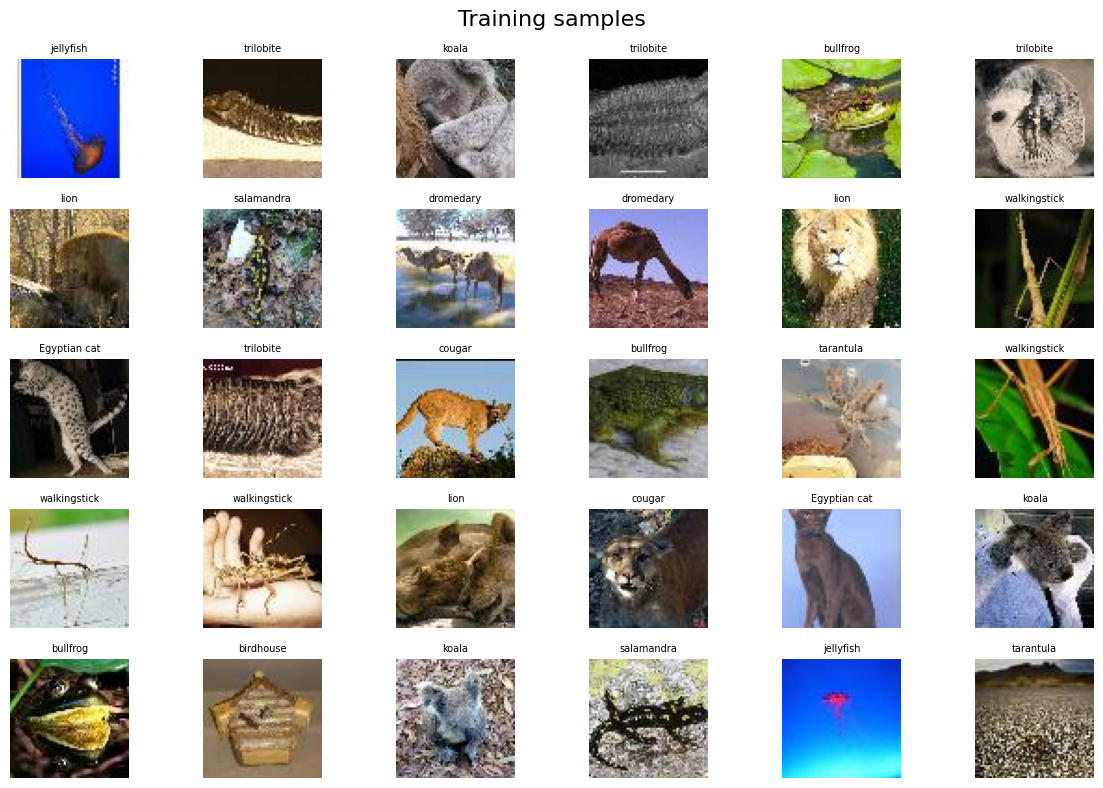

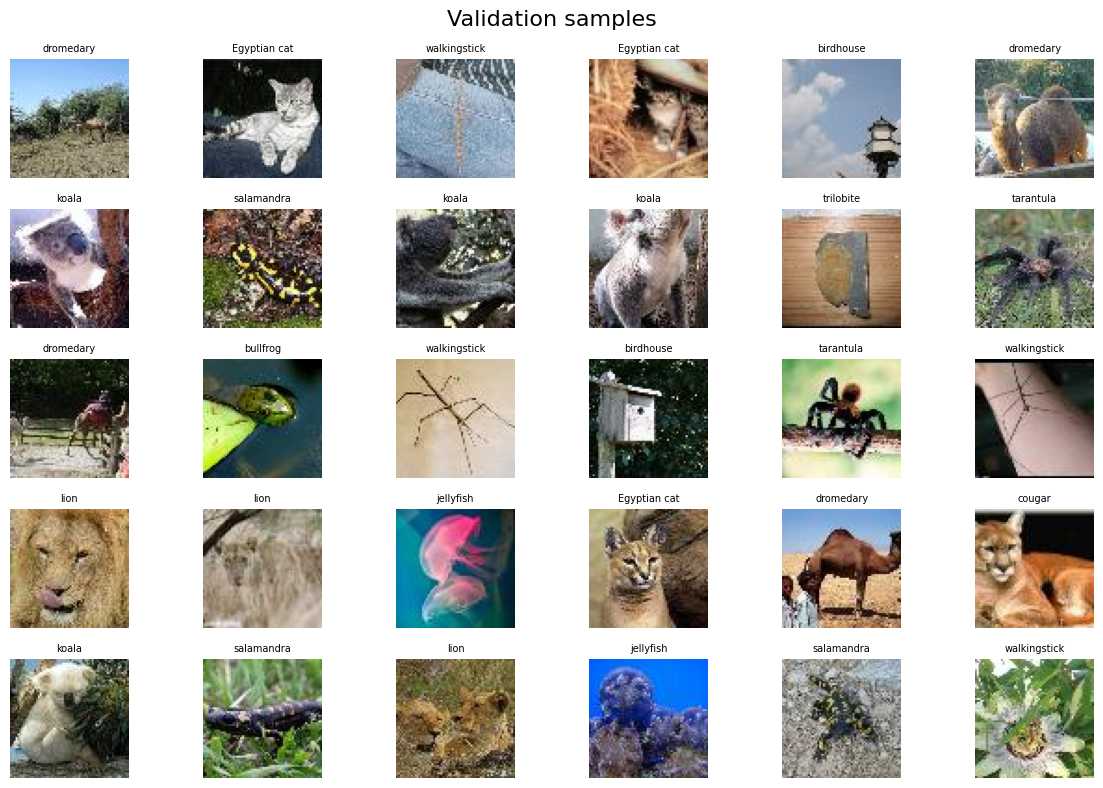

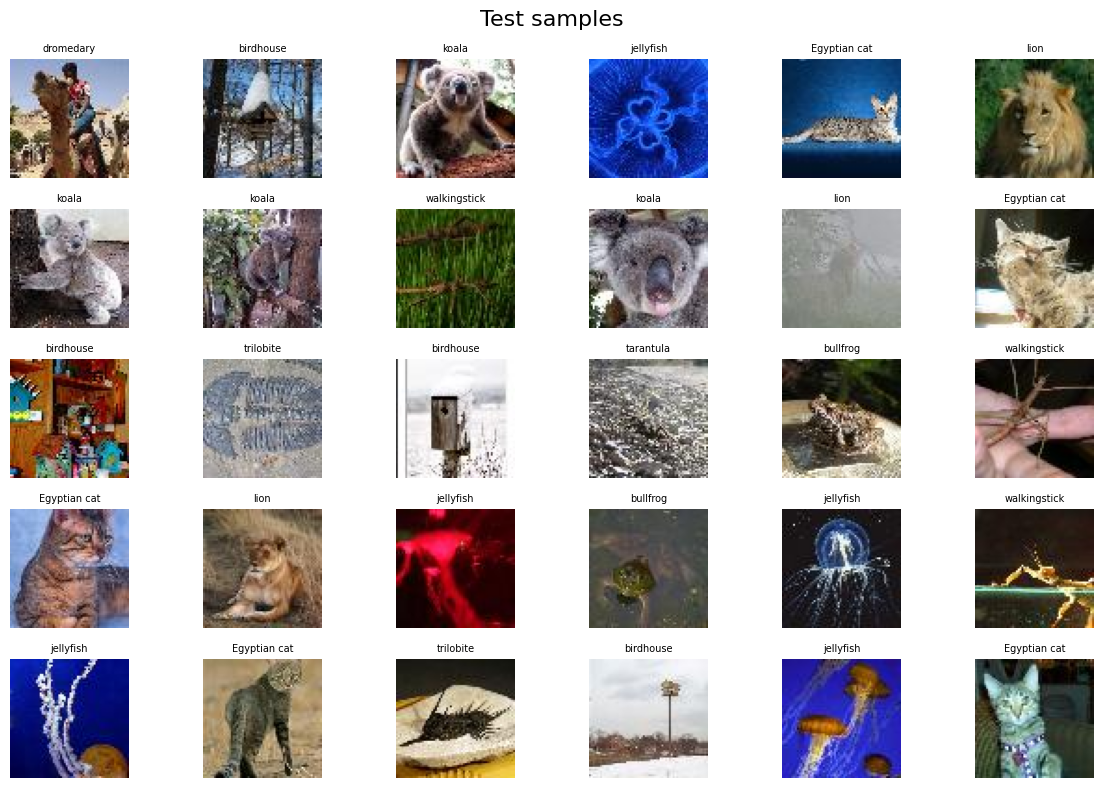

In [ ]:
# Apply the funtion for three datasets taining, validation and test

display_images(X_train, y_train, class_names, title="Training samples")
display_images(X_valid, y_valid, class_names, title="Validation samples")
display_images(X_test, y_test, class_names, title="Test samples")

**3.2. Data Preparation**

Data preprocess using sacling and augmentation

In [ ]:
no_classes = 12
input_shape = (64, 64, 3)

# Scale image pixel values to [0, 1] as its more effectively when inputs are normalized.
X_train_f = X_train.astype("float32") / 255.0
X_valid_f = X_valid.astype("float32") / 255.0
X_test_f  = X_test.astype("float32")  / 255.0


In [ ]:
# Data augmentation pipeline
# Model generalize better by creating slight variations of images
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
], name="aug_layer")




---



**3.3 Create CNN model**

The function build_model_CNN(hp) defines a Convolutional Neural Network (CNN) architecture with hyperparameters tuned using Keras Tuner. The model starts with light data augmentation layers using random flips, rotations, and zooms in order to improve generalization.
It then has four convolutional blocks: each block applies convolutional filters to extract features, followed by pooling layers to reduce spatial dimensions.
Some blocks also include batch normalization and ReLU activation for stability and non-linearity.
After feature extraction, a global average pooling layer reduces the feature maps to a single vector, which is passed through a tunable dense layer with dropout for regularization.
The final layer is a softmax output with as many neurons as the number of classes.
The model is compiled with the Adam optimizer and sparse categorical crossentropy loss for multi-class classification.

In [ ]:
def build_model_CNN(hp):
    # n_dense: number of neurons in the dense layer to controls model capacity
    # drop_rate: dropout rate for regularization to prevents overfitting
    n_dense   = hp.Choice("n_dense", [64, 96, 128])
    drop_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)

    # L2 regularization
    L2 = tf.keras.regularizers.l2(1e-4)

    model = tf.keras.Sequential(name="cnn")

    # Data augmentation  with random flips, rotations, and zooms to improve generalization
    model.add(tf.keras.layers.RandomFlip("horizontal", input_shape=input_shape))
    model.add(tf.keras.layers.RandomRotation(0.05))
    model.add(tf.keras.layers.RandomZoom(0.1))
    model.add(tf.keras.layers.RandomContrast(0.1))

    # Block 1
    model.add(tf.keras.layers.Conv2D(hp.Choice("filters_1", [8, 16]), 3, padding="same",
                                     activation="relu",
                                     kernel_regularizer=L2))
    model.add(tf.keras.layers.MaxPool2D(2))

    # Block 2
    # ReLU adds non-linearity for better feature learning
    model.add(tf.keras.layers.Conv2D(hp.Choice("filters_2", [16, 32]), 3, padding="same",
                                     use_bias=False, activation=None,
                                     kernel_regularizer=L2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D(2))

    # Block 3
    model.add(tf.keras.layers.Conv2D(hp.Choice("filters_3", [16, 32]), 3, padding="same",
                                     activation="relu",
                                     kernel_regularizer=L2))
    model.add(tf.keras.layers.MaxPool2D(2))

    # Block 4
    model.add(tf.keras.layers.Conv2D(hp.Choice("filters_4", [16, 32]), 3, padding="same",
                                     use_bias=False, activation=None,
                                     kernel_regularizer=L2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D(2))

    # Head
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(n_dense, activation="relu",
                                    kernel_regularizer=L2))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(no_classes, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


*   Adam optimizer used as it adapts the learning rate for each parameter automatically, which often leads to faster convergence and better performance
*   The learning rate controls the step size at each update with value of 0.001 (1e-3) as it balances learning speed and stability.

*   Sparse Categorical Crossentropy is a loss function used for multi-class classification where labels are given as integers

**3.3 Tuner Setup for model CNN**

Hyperparameter tuning using Bayesian Optimization

In [ ]:
tuner = kt.BayesianOptimization(
build_model_CNN,
objective=Objective("val_accuracy", direction="max"),
max_trials=10,
seed=seed,
overwrite=True,
directory="tuning",
project_name="cnn",
)

# Early stopping

# Monitors validation accuracy and stops training if it does not improve
# for 6 consecutive epochs (patience=6).
# min_delta=2e-3 improvements smaller than 0.002 are ignored.
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", mode="max", patience=6, min_delta=2e-3, restore_best_weights=True
)

# Reduce learning rate on plateau

# Monitors validation loss as if it stops improving for 4 epochs,
# the learning rate is reduced by factor=0.5.
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


*   BayesianOptimization as it efficiently explores hyperparameters (filters, dense units, dropout, etc.) by learning from past trials.
*   EarlyStopping used to prevents overfitting and saves time by halting training once the model stops improving.
*   ReduceLROnPlateau use as it allows the model to escape "flat" regions in training by lowering the learning rate.

**3.4. Run the Search for model CNN**

In [ ]:
# Timer to track the execution time for the mode
def format_hms(seconds):
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f"{h:02d}h {m:02d}m {s:02d}s"

In [ ]:
# Change hyperparameter_tuning flag if need to run this code again
hyperparameter_tuning = True
if hyperparameter_tuning:

    t0 = time.time()

    # Perform hyperparameter search using the training and validation sets
    tuner.search(
        X_train_f, y_train,
        epochs=100,
        validation_data=(X_valid_f, y_valid),
        callbacks=[early_stop, plateau],
        verbose=1,
    )

    # total elapsed time in hours:minutes:seconds
    total_time_CNN = format_hms(time.time() - t0)
    print("Total elapsed time:", total_time_CNN)


    # Retrieve the best-performing model from the tuning trials
    best_model = tuner.get_best_models(1)[0]
    test_loss, test_acc = best_model.evaluate(X_test_f, y_test, verbose=0)
    print(f"\nBest model TEST accuracy: {test_acc:.3f}")


    # Save best model to a RajapakshaSenadherage_NirmaDilrukshi-CNN.keras file
    best_model.save(filename_CNN)
    print("Saved ->", filename_CNN)

    # Prevent re-running tuning
    hyperparameter_tuning = False

else:
    # Load saved CNN and show architecture
    model = tf.keras.models.load_model(filename_CNN)
    print("Loaded: ", filename_CNN)
    print("Trainable params: ", model.count_params())
    model.summary()

Trial 8 Complete [00h 12m 42s]
val_accuracy: 0.4116666615009308

Best val_accuracy So Far: 0.5008333325386047
Total elapsed time: 01h 34m 53s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
64                |96                |n_dense
0.1               |0.1               |dropout_rate
8                 |8                 |filters_1
32                |16                |filters_2
32                |32                |filters_3
32                |32                |filters_4

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.1687 - loss: 2.3882 - val_accuracy: 0.0942 - val_loss: 2.6519 - learning_rate: 0.0010
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.2627 - loss: 2.1396 - val_accuracy: 0.1258 - val_loss: 2.7524 - learning_rate: 0.0010
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.3166 - loss: 2.0106 - val_accuracy: 0.1742 - val_loss: 2.5752 - learning_rate: 0.0010
Epoch 4/100
132/132 

In [ ]:
best_model = tuner.get_best_models(1)[0]
test_loss, test_acc = best_model.evaluate(X_test_f, y_test, verbose=0)

print(f"\nBest model TEST accuracy: {test_acc:.3f}")


Best model TEST accuracy: 0.502


***Note***
*Reproducibility. I fixed all random seeds (Python, NumPy, TensorFlow), dataset shuffling with a fixed seed, seeded the augmentation layers, and seeded the Keras Tuner.*
*Despite these controls, exact reproducibility can still vary across hardware/TF versions due to non-deterministic GPU kernels.*
*To ensure consistent reporting, I saved the tuned model (RajapakshaSenadherage_NirmaDilrukshi-CNN.keras) and the best hyperparameters (JSON), and all metrics/figures in this report were generated by reloading that saved model rather than retraining.*

**3.5 Summary**

*   Hyperparameter tuning ran for ~1hr 33m and explored 10 configurations.

*   The best CNN achieved 46.9% validation accuracy during tuning.

*   When tested on unseen data, the final model reached 50.2% test accuracy.
*   The trained model was saved as RajapakshaSenadherage_NirmaDilrukshi-CNN.keras.










**3.6 Summary of CNN Architecture**

In [ ]:
best_model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 16)       │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,972 (81.92 KB)

 Trainable params: 20,876 (81.55 KB)

 Non-trainable params: 96 (384.00 B)

*   CNN model begins with data augmentation layers
*   Has four convolutional blocks with increasing filter sizes (8 -> 32) with max-pooling to progressively reduce spatial dimensions
*   Two of blocks include batch normalization and ReLU for stability and non-linearity
*   After feature extraction, the model uses global average pooling to reduce feature maps, with a dense layer with 64 units and dropout for regularization

Overall, the network has 20,972 parameters (~20,876 trainable)



---



---



**Task 4**

**4.1 Create learning using MobileNetV3Small**

The following model


*   Use additional custom layers for classification
*   Input images first pass through a data augmentation pipeline (flip, rotation, zoom, contrast) and MobileNetV3 preprocessing
*    A custom dense head layer (72 units, ReLU, L2 regularization) and dropout (0.3) are applied to improve generalization
*   The final softmax output layer predicts across the target number of classes.

The model is compiled with the Adam optimizer (learning rate = 1e-3) and sparse categorical crossentropy loss, using accuracy as the evaluation metric.

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="aug")

base = MobileNetV3Small(include_top=False, weights="imagenet", input_shape=input_shape)
base.trainable = False

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Lambda(mobilenet_v3.preprocess_input)(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dense(72, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4),
                 name="dense_head")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(no_classes, activation="softmax", name="pred")(x)

mnet = keras.Model(inputs, outputs, name="MobileNetV3Small")
mnet.compile(optimizer=keras.optimizers.Adam(1e-3),
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

mnet.summary(line_length=120)


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_2 (InputLayer)                          │ (None, 64, 64, 3)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ aug (Sequential)                                    │ (None, 64, 64, 3)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ lambda (Lambda)                                     │ (None, 64, 64, 3)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ MobileNetV3Small (Functional)                       │ (None, 2, 2, 576)                      │               939,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ gap (GlobalAveragePooling2D)                        │ (None, 576)                            │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_head (Dense)                                  │ (None, 72)                             │                41,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_1 (Dropout)                                 │ (None, 72)                             │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ pred (Dense)                                        │ (None, 12)                             │                   
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 981,540 (3.74 MB)

 Trainable params: 42,420 (165.70 KB)

 Non-trainable params: 939,120 (3.58 MB)

In total, the model has 981,540 parameters, of only 42,420 are trainable, keeping training efficient while leveraging pretrained feature extraction.

**4.2 Show summary for the first 4 and last 4 layers**

In [ ]:
def show_layers_summaries(model, first_n=4, last_n=4):
    print("First 4 layers")
    for i, layer in enumerate(model.layers[:first_n]):
        print(f"{i:2d} | {layer.name:30s} | {layer.__class__.__name__:20s} | params={layer.count_params()}")

    print("Last 4 layers")
    for i, layer in enumerate(model.layers[-last_n:]):
        j = len(model.layers) - last_n + i
        print(f"{j:2d} | {layer.name:30s} | {layer.__class__.__name__:20s} | params={layer.count_params()}")

show_layers_summaries(mnet)


First 4 layers
 0 | input_layer_2                  | InputLayer           | params=0
 1 | aug                            | Sequential           | params=0
 2 | lambda                         | Lambda               | params=0
 3 | MobileNetV3Small               | Functional           | params=939120
Last 4 layers
 4 | gap                            | GlobalAveragePooling2D | params=0
 5 | dense_head                     | Dense                | params=41544
 6 | dropout_1                      | Dropout              | params=0
 7 | pred                           | Dense                | params=876


First four layers with input pipeline:

*   Input Layer (accepts 64 x 64 x 3 images)
*   Data augmentation: flip, rotate, zoom, contrast
*   Preprocessing for MobileNetV3(lambda)
*   Frozen pretrained backbone with ~939k parameters(MobileNetV3Small)

---

The last four layers with classification head:

*   Global Average Pooling reduces feature maps to a vector
*   128-unit Dense layer with ~41k parameters, adds trainable capacity (dense_head)
*   Regularization to reduce overfitting (dropout_3)
*   Dense layer with 12 outputs for softmax classification (pred)

In [ ]:
# Convert arrays into tf.data.Dataset pipelines
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=len(X_train), seed=seed).batch(batch_size).prefetch(1)

val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
val_ds = val_ds.batch(batch_size).prefetch(1)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(batch_size).prefetch(1)


Above code used

Batching: Groups samples into mini-batches size 32.

Shuffling: Randomizes training data order of each epoch with fixed seed for reproducibility.

Validation/Test sets: Only batched without no shuffle to preserve order and ensure consistent evaluation.

**4.4 Training MobileNet model**

This following model applies transfer learning using a frozen MobileNetV3Small backbone.
A classification head is trained on top.
The design helps prevent overfitting while leveraging pretrained features.
Training is optimized with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.
Callbacks (ReduceLROnPlateau, EarlyStopping) control learning rate adaptively and stop training early to improve efficiency.

In [ ]:
# assume 'base' is a frozen MobileNetV3Small and inputs are preprocessed
base.trainable = False

# Classification head
x = layers.GlobalAveragePooling2D(name="gap")(base.output)
x = layers.BatchNormalization(name="bn_gap")(x)
x = layers.Dense(64, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4),
                 name="dense_head")(x)
x = layers.Dropout(0.4, name="drop")(x)
outputs = layers.Dense(no_classes, activation="softmax", name="pred")(x)

# Build and compile the model
mnet = keras.Model(base.input, outputs, name="MobileNetV3Small")

opt = keras.optimizers.Adam(learning_rate=5e-4)
mnet.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks to improve training
plateau = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early   = callbacks.EarlyStopping(monitor="val_loss", patience=8, min_delta=1e-3, restore_best_weights=True, verbose=1)

t0 = time.time()
history = mnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[plateau, early],
    verbose=2,
)

total_time_mobile = format_hms(time.time() - t0)

print(f"Training time: {total_time_mobile}")

Epoch 1/200
132/132 - 15s - 114ms/step - accuracy: 0.2017 - loss: 2.6707 - val_accuracy: 0.4283 - val_loss: 1.8242 - learning_rate: 5.0000e-04
Epoch 2/200
132/132 - 9s - 65ms/step - accuracy: 0.3976 - loss: 1.8732 - val_accuracy: 0.5225 - val_loss: 1.5394 - learning_rate: 5.0000e-04
Epoch 3/200
132/132 - 9s - 69ms/step - accuracy: 0.4752 - loss: 1.6015 - val_accuracy: 0.5567 - val_loss: 1.4120 - learning_rate: 5.0000e-04
Epoch 4/200
132/132 - 7s - 50ms/step - accuracy: 0.5279 - loss: 1.4413 - val_accuracy: 0.5808 - val_loss: 1.3393 - learning_rate: 5.0000e-04
Epoch 5/200
132/132 - 6s - 42ms/step - accuracy: 0.5655 - loss: 1.3473 - val_accuracy: 0.5967 - val_loss: 1.2907 - learning_rate: 5.0000e-04
Epoch 6/200
132/132 - 7s - 50ms/step - accuracy: 0.5890 - loss: 1.2473 - val_accuracy: 0.6008 - val_loss: 1.2588 - learning_rate: 5.0000e-04
Epoch 7/200
132/132 - 6s - 42ms/step - accuracy: 0.6138 - loss: 1.1829 - val_accuracy: 0.6117 - val_loss: 1.2253 - learning_rate: 5.0000e-04
Epoch 8/200

**4.5 Save the model**

In [ ]:
mnet.save(filename_Mobile)
print("Saved ->", filename_Mobile)

Saved -> RajapakshaSenadherage_NirmaDilrukshi-MobileNetV3Small.keras


**4.6 Learning curves**

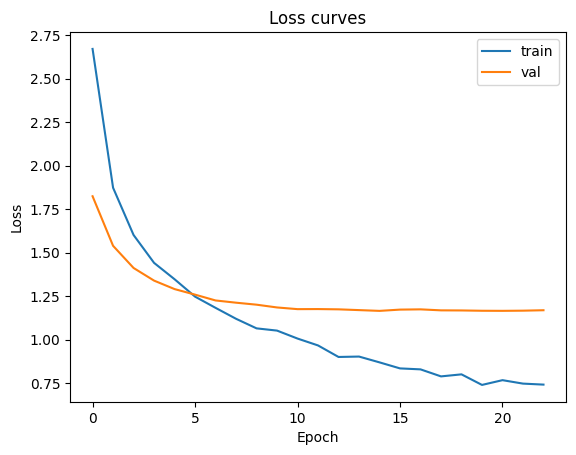

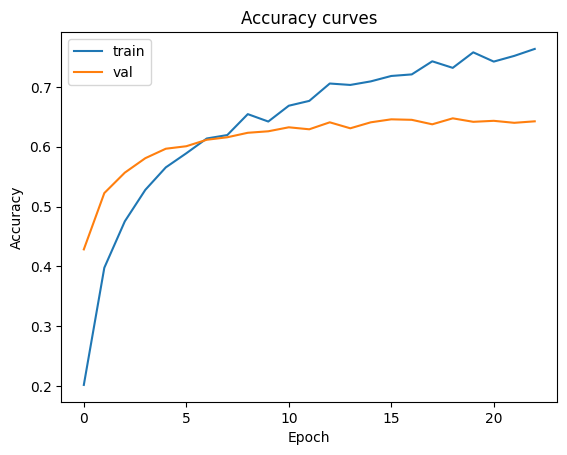

In [ ]:
# Plot learning curves
plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss curves")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy curves")
plt.show()




*   The model fits the training data well but begins to overfit after ~10 epochs, as validation accuracy plateaus around 62%.
*   Training accuracy (blue) continues to rise toward ~0.75, while validation accuracy (orange) quickly increases to ~0.63 - 0.65 before flattening out.
*   The widening gap between training and validation curves indicates that the model is memorizing the training set rather than improving generalization.
*   This suggests that keeping the base network fully frozen limits performance on unseen data.



---



---



**5 Comparisons**

**5.1 Load saved models**

In [ ]:
# Reload CNN model
cnn_loaded = keras.models.load_model("RajapakshaSenadherage_NirmaDilrukshi-CNN.keras")
cnn_loaded.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 16)       │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,726 (245.03 KB)

 Trainable params: 20,876 (81.55 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 41,754 (163.11 KB)

In [ ]:
# Reload MobileNetV3Small model
mnet_loaded = keras.models.load_model("RajapakshaSenadherage_NirmaDilrukshi-MobileNetV3Small.keras")
mnet_loaded.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 64, 64, 3) │          0 │ input_layer_1[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 32, 32,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 32, 32,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 33, 33,    │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 16, 16,    │          0 │ re_lu_2[0][0],    │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        256 │ expanded_conv_sq

 Total params: 1,056,854 (4.03 MB)

 Trainable params: 38,860 (151.80 KB)

 Non-trainable params: 940,272 (3.59 MB)

 Optimizer params: 77,722 (303.61 KB)

**5.2 Execute time and Complexity**

In [ ]:
# counts only trainable weights
def count_trainable_params(model) -> int:
    return int(np.sum([np.prod(w.shape) for w in model.trainable_weights]))

base.trainable = False

cnn_trainable_params  = count_trainable_params(cnn_loaded)
mnet_trainable_params = count_trainable_params(mnet_loaded)

# Execute time
print(" Timing ")
print(f"CNN tuning time: {total_time_CNN}")
print(f"MobileNetV3Small train: {total_time_mobile}")

# Trainable parameters
print("\n Model Complexity (trainable parameters)")
print(f"CNN trainable params:        {cnn_trainable_params:,}")
print(f"MobileNetV3Small (head only):{mnet_trainable_params:,}")


 Timing 
CNN tuning time: 01h 33m 19s
MobileNetV3Small train: 00h 02m 51s

 Model Complexity (trainable parameters)
CNN trainable params:        20,876
MobileNetV3Small (head only):38,860


Based on the above data

*   The CNN is smaller but slower to optimize due to hyperparameter tuning
*   MobileNetV3Small leverages pretrained features for faster training with slightly higher complexity in the classification head.

**5.3 Performance (precision, recall, and F1 score)**

True labels are first extracted from the test dataset.
Predictions are generated using both the saved CNN model and the MobileNetV3Small model.
For each model, performance is evaluated with a classification report (precision, recall, F1-score per class) and the overall accuracy score.

In [ ]:
# Get ground truth labels from test_ds
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# CNN predictions
y_pred_cnn = np.argmax(cnn_loaded.predict(test_ds), axis=1)
print(" CNN Performance on Test Set ")
print(classification_report(y_true, y_pred_cnn, digits=4))
print("Overall accuracy:", accuracy_score(y_true, y_pred_cnn))

# MobileNetV3Small predictions
y_pred_mnet = np.argmax(mnet_loaded.predict(test_ds), axis=1)
print("\n MobileNetV3Small Performance on Test Set ")
print(classification_report(y_true, y_pred_mnet, digits=4))
print("Overall accuracy:", accuracy_score(y_true, y_pred_mnet))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
 CNN Performance on Test Set 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        50
           1     0.0998    0.8800    0.1792        50
           2     0.0000    0.0000    0.0000        50
           3     0.0000    0.0000    0.0000        50
           4     0.2014    0.5800    0.2990        50
           5     1.0000    0.1600    0.2759        50
           6     0.0000    0.0000    0.0000        50
           7     0.0000    0.0000    0.0000        50
           8     1.0000    0.1000    0.1818        50
           9     0.0000    0.0000    0.0000        50
          10     0.0000    0.0000    0.0000        50
          11     0.0000    0.0000    0.0000        50

    accuracy                         0.1433       600
   macro avg     0.1918    0.1433    0.0780       600
weighted avg     0.1918    0.1433    0.0780       600

Overall accuracy: 0.14333333333333334


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step

 MobileNetV3Small Performance on Test Set 
              precision    recall  f1-score   support

           0     0.4490    0.4400    0.4444        50
           1     0.5750    0.4600    0.5111        50
           2     0.6444    0.5800    0.6105        50
           3     0.3704    0.4000    0.3846        50
           4     0.6111    0.6600    0.6346        50
           5     0.8333    0.9000    0.8654        50
           6     0.5957    0.5600    0.5773        50
           7     0.5094    0.5400    0.5243        50
           8     0.8400    0.8400    0.8400        50
           9     0.4727    0.5200    0.4952        50
          10     0.7736    0.8200    0.7961        50
          11     0.6957    0.6400    0.6667        50

    accuracy                         0.6133       600
   macro avg     0.6142    0.6133    0.6125       600
weighted avg     0.6142    0.6133    0.6125       600

Overall accuracy: 0.6133333333333333


Based on the performance statistics above

*CNN Model*
*   Overall accuracy of only 14.3% on the test set.
*   Precision, recall, and F1-scores are very low across most classes, with the model struggling to correctly identify many categories.
*   The macro and weighted averages (~0.19 precision, 0.14 recall, 0.08 F1) confirm poor generalization.

This shows that the CNN model did not learn effective feature representations from scratch with the given data and tuning.

*MobileNetV3Small*

*   Overall accuracy of 61.3% on the test set
*   Performance is consistent across most classes, with achieving precision and recall values above 0.05-0.85.
*   The macro and weighted averages (~ 0.61 precision/recall/F1) indicate balanced performance across classes

This demonstrates the strength MobileNetV3Small, where pretrained features from ImageNet significantly improve classification performance compared to training from scratch.

**5.4 Confusion Matrices of the two models for the test set**

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


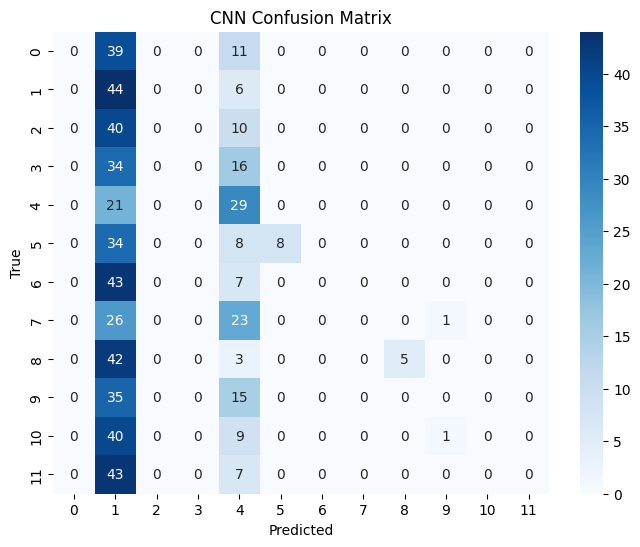

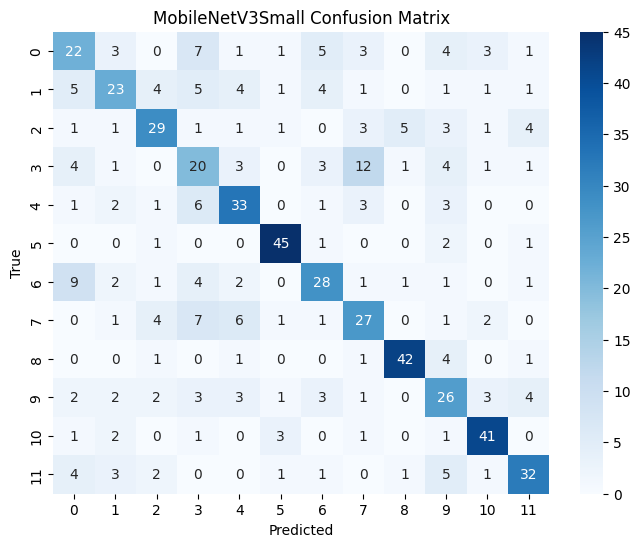

In [ ]:

# get true labels from test_ds
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# CNN predictions
y_pred_cnn = np.argmax(cnn_loaded.predict(test_ds), axis=1)

# MobileNetV3Small predictions
y_pred_mnet = np.argmax(mnet_loaded.predict(test_ds), axis=1)

# plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(no_classes),
                yticklabels=range(no_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_conf_matrix(y_true, y_pred_cnn, "CNN Confusion Matrix")
plot_conf_matrix(y_true, y_pred_mnet, "MobileNetV3Small Confusion Matrix")


*CNN Confusion Matrix*

*   Struggles heavily across all classes, with predictions spread widely across incorrect labels
*   Many true samples are misclassified into class 1
*   Biased toward certain categories
*   Correct predictions are low, confirming the poor overall accuracy (~14%)

The confusion pattern suggests the CNN trained from scratch could not extract strong features from the data.

*MobileNetV3Small Confusion Matrix*

*   Clearer diagonals with many predictions match the true labels
*   Most classes (e.g., 2, 4, 5, 8, 10, 11) show 30 - 45 correct predictions out of 50 which indicating strong performance
*   The spread of errors is far smaller compared to the CNN
*   With higher test accuracy (~61%), it indicate transfer learning produces balanced and reliable predictions

**5.5 Comparison of images from the test set where**

1.   **Both models correctly classified**
2.   **Both models incorrectly classified**
3.   **CNN classified Correctly but retrained MobileNetV3Small did not**
5.   **Retrained MobileNetV3Small classified correctly but CNN did not**

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


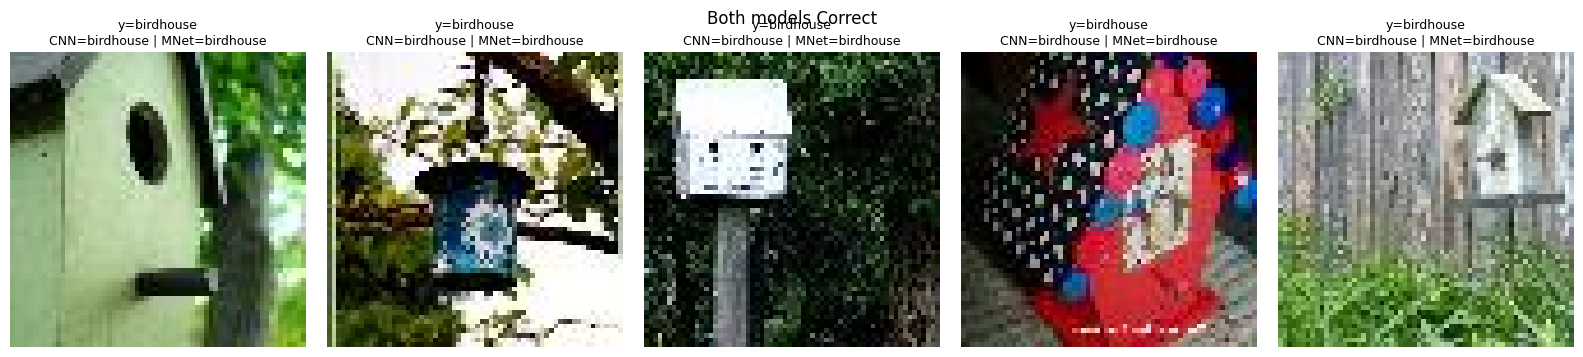

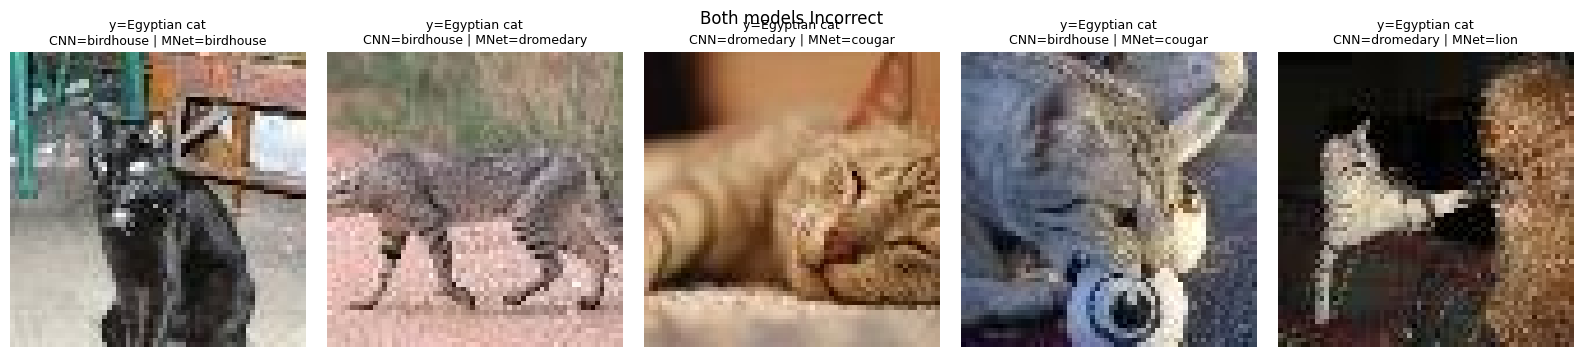

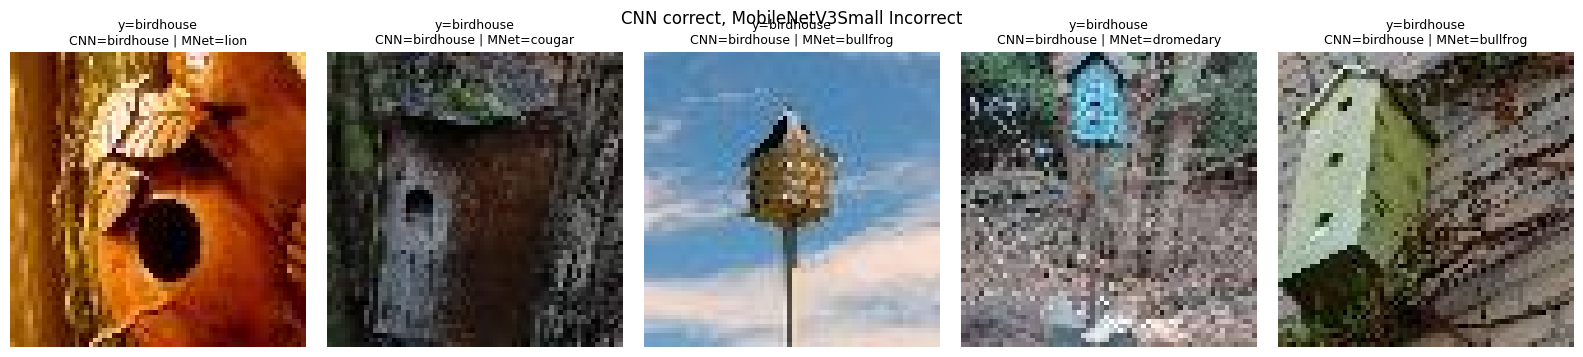

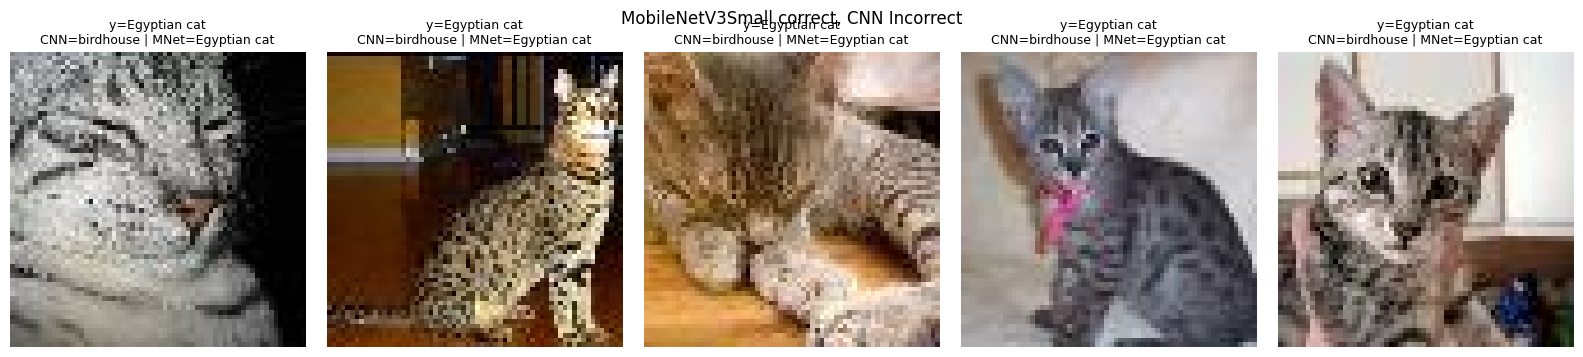

In [ ]:
# Fix image scaling for display
def to_display(img):
    arr = np.asarray(img)

    if arr.dtype == np.uint8:
        return arr

    mn, mx = float(arr.min()), float(arr.max())
    if mx > 1.5:
        arr = arr / 255.0
    elif mn < -0.1 and mx <= 1.0:
        arr = (arr + 1.0) / 2.0

    return np.clip(arr, 0.0, 1.0)


# collect test arrays and labels
X_test_np = np.concatenate([x for x, _ in test_ds], axis=0)
y_true    = np.concatenate([y for _, y in test_ds], axis=0)

# Predictions from both models
y_pred_cnn  = np.argmax(cnn_loaded.predict(test_ds), axis=1)
y_pred_mnet = np.argmax(mnet_loaded.predict(test_ds), axis=1)

# Correctness masks
cnn_ok  = (y_pred_cnn == y_true)
mnet_ok = (y_pred_mnet == y_true)

# four categories
idx_both_correct = np.where(cnn_ok & mnet_ok)[0]
idx_both_wrong   = np.where(~cnn_ok & ~mnet_ok)[0]
idx_cnn_only     = np.where(cnn_ok & ~mnet_ok)[0]
idx_mnet_only    = np.where(~cnn_ok & mnet_ok)[0]

# use class names
try:
    class_names
except NameError:
    class_names = [str(i) for i in range(no_classes)]

def label_name(y):
    return class_names[int(y)]

# Show samples from each category
def show_samples(indices, title, max_n=5):
    n = min(len(indices), max_n)
    if n == 0:
        print(f"[{title}] No samples available.")
        return
    plt.figure(figsize=(3.2*n, 3.6))
    for i, idx in enumerate(indices[:n], 1):
        plt.subplot(1, n, i)
        img_disp = to_display(X_test_np[idx])
        plt.imshow(img_disp)
        plt.axis("off")

        t  = int(y_true[idx])
        pc = int(y_pred_cnn[idx])
        pm = int(y_pred_mnet[idx])
        plt.title(f"y={label_name(t)}\nCNN={label_name(pc)} | MNet={label_name(pm)}",
                  fontsize=9)
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# Display up to 5 from each category
show_samples(idx_both_correct, "Both models Correct", max_n=5)
show_samples(idx_both_wrong,   "Both models Incorrect",   max_n=5)
show_samples(idx_cnn_only,     "CNN correct, MobileNetV3Small Incorrect", max_n=5)
show_samples(idx_mnet_only,    "MobileNetV3Small correct, CNN Incorrect", max_n=5)


**Predictions Analysis**

The outputs illustrate cases where both models were correct, both were incorrect, or only one of the models predicted correctly.

When both models are correct, the predictions are consistent and contant with clear class features.

If both are wrong, it indicate the limitations in feature representation.

In some outputs, CNN is correct while MobileNetV3Small is wrong, but these can be relatively rare based on the accuracy, reflecting MobileNet's stronger generalization.

MobileNetV3Small often corrects CNN's mistakes, which indicate the benefit of pretrained features.